In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

## Sampling of a set of observations according to a Gaussian Mixture law

In [2]:
def generate(X, P, n):
    """
    Function that generates a set of (hidden) observations according to a distribution probability
    - X is the 1D-array containing the values x_i
    - P is the 1D-array containing the values p_i, starting at indice 0
    - n is the number of values to be generated
    """
    assert np.sum(P) == 1, "The sum of values of P must be 1"
    C = np.cumsum(P)
    U = np.random.rand(n)
    values = np.zeros(n)
    for k in range(n):
        i = 0
        while C[i] < U[k]:
            i += 1
        values[k] = X[i]
    return values

## Useful functions

Temperature profiles

In [3]:
def T_const(n):
    return 1

def T_exp(n):
    return(1 + 99*np.exp(-1.5*n))

def T1(n):
    T0 = 100
    r = 1.5
    a= 0.02
    b=20
    return np.maximum(np.tanh(n/(2*r)) + (T0 - b*2*np.sqrt(2)/(3*np.pi))*a**(n/r) + b*np.sinc(3/4 + n/(np.pi*r)),0.1)

Tempered EM

In [4]:
def EM(X, m, d, T, mu_start, maxIter=100):
    # m: number of classes
    # d : dimension of the observations
    # Initialization of alpha_t, mu_t and sigma_t
    # T : Temperature profile
    n = len(X)
    alpha_previous = 1/m * np.ones(m)
    alpha_t = 1/m * np.ones(m)
    mu_previous = mu_start.copy()
    mu_t = mu_previous.copy()
    sigma_previous = np.array([np.eye(2) for _ in range(m)])
    sigma_t = np.array([np.eye(2) for _ in range(m)])
    criterion = np.inf
    n_iter = 0
    
    for n_iter in range(100):
        # Expectation: compute the new tho
        N = np.zeros((n, m)) # Matrix N[i, k] = (N(x_i|mu_k, sigma_k)*alpha_k)**(1/T_n)
        for i in range(n):
            for k in range(m):
                N[i, k] = multivariate_normal.pdf(X[i], mean=mu_t[k], cov=sigma_t[k], allow_singular=True)* alpha_t[k]
        tho = np.ones((n, m))
        for i in range(n):
            for k in range(m):
                tho[i, k] = N[i, k]/np.sum(N[i])
                tho[i, k] = tho[i, k]**(1/T(n_iter))
        sum_tho = np.sum(tho, axis = 1)
        tho = tho/np.reshape(sum_tho, (n,1))
                
        # Maximization: compute the new alphas, mus, sigmas and update the criterion
        alpha_previous = alpha_t.copy()
        mu_previous =mu_t.copy()
        sigma_previous = sigma_t.copy()
        for j in range(m):
            alpha_t[j] = np.sum(tho[:, j]) / np.sum(tho)
            mu_t[j] = (1/ np.sum(tho[:, j])) * np.sum(np.array([tho[i, j] * X[i] for i in range(n)]), axis=0) 
            sigma_t[j] = np.sum(np.array([tho[i, j] * np.outer(X[i]- mu_t[j], X[i]- mu_t[j]) for i in range(len(X))]), axis=0)  / np.sum(tho[:, j])
        #criterion = max(np.linalg.norm(alpha_t - alpha_previous)/np.linalg.norm(alpha_previous), np.linalg.norm(mu_t - mu_previous)/np.linalg.norm(mu_previous), np.linalg.norm(sigma_t - sigma_previous)/np.linalg.norm(sigma_previous))
        #n_iter += 1
        '''if n_iter==0:
            print(mu_t)
            print(sigma_t)'''
    return alpha_t, mu_t, sigma_t

## Experimentation on an easy set

In [ ]:
# Set model parameters
m = 3
alpha = np.array([0.3, 0.3, 0.4])
mu = np.array([np.array([-7., -5.]), np.array([-7., 5.]), np.array([7., 0.])])
sigma = np.array([np.eye(2) for _ in range(m)])
mu_start = np.array([np.array([1., -1.]), np.array([1.,  0.]), np.array([1., 1.])])
#Generate easy observations
N_obs = 500
# Generate hidden variables
Z = generate(np.arange(0, 3), alpha, N_obs)
Z = np.intc(Z)
# Generate observations
X = np.array([np.random.multivariate_normal(mean=mu[Z[i]], cov=sigma[Z[i]]) for i in range(N_obs)])

# Estimate parameters
alpha_easy, mu_easy, sigma_easy = EM(X, m=3, d=2, mu_start=mu_start, T=T_const)  # Classical EM
alpha_temp_easy, mu_temp_easy, sigma_temp_easy = EM(X, m=3, d=2, mu_start=mu_start, T=T1)  # Tempered EM

# Display
plt.scatter(X[:,0], X[:,1], s=2, color='y', label="dataset")
plt.scatter(mu[:,0], mu[:,1], marker='x', s=100, c='k', label='real values of mu')
plt.scatter(mu_start[:,0], mu_start[:,1], marker='x', s=100, c='g', label='start values of mu for the EM')
plt.scatter(mu_easy[:,0], mu_easy[:,1], marker='x', s=100, c='r', label='mu estimated with classical EM')
plt.scatter(mu_temp_easy[:,0], mu_temp_easy[:,1], marker='x', s=100, c='b', label='mu estimated with profile T1')
print("mu const", mu_easy)
print('mu tempered', mu_temp_easy)
plt.legend(loc="best")
plt.title("Estimations using different temperature profiles")
plt.show()

## Experimentation on a hard dataset

In [ ]:
# Set model parameters
np.random.seed(3)
m = 3
alpha = np.array([0.3, 0.3, 0.4])
mu = np.array([np.array([-7., -1.]), np.array([-7.,  1.]), np.array([7., 0.])])
sigma = np.array([np.eye(2) for _ in range(m)])
mu_start = np.array([np.array([1., -1.]), np.array([1.,  3.]), np.array([1., 1.])])

# Generate hard observations 
N_obs = 500
# Generate hidden variables
Z = generate(np.arange(0, 3), alpha, N_obs)
Z = np.intc(Z)
# Generate observations
X = np.array([np.random.multivariate_normal(mean=mu[Z[i]], cov=sigma[Z[i]]) for i in range(N_obs)])

# Estimate parameters
alpha_hard, mu_hard, sigma_hard = EM(X, m=3, d=2, mu_start=mu_start, T=T_const)
alpha_temp_hard, mu_temp_hard, sigma_temp_hard = EM(X, m=3, d=2, mu_start=mu_start, T=T1)

# Display
plt.scatter(X[:,0], X[:,1], s=2, color='y', label="dataset")
plt.scatter(mu[:,0], mu[:,1], marker='x', s = 100, c='k', label='real values of mu')
plt.scatter(mu_start[:,0], mu_start[:,1], marker='x', s=100, c='g', label='start values of mu for the EM')
plt.scatter(mu_hard[:,0], mu_hard[:,1], marker='x', s = 100, c='r', label='mu estimated with classical EM')
plt.scatter(mu_temp_hard[:,0], mu_temp_hard[:,1], marker='x', s = 100, c='b', label='mu estimated with profile T1')

plt.legend(loc="best")
plt.title("Estimations using different temperature profiles")
plt.show()
print("mu estimated with classical EM:", mu_hard)
print('mu estimated with profile T1', mu_temp_hard)

# Experiment on hard dataset with a 2vs1 start

In [ ]:
# Set model parameters
np.random.seed(3)
m = 3
alpha = np.array([0.3, 0.3, 0.4])
mu = np.array([np.array([-7., -1.]), np.array([-7.,  1.]), np.array([7., 0.])])
sigma = np.array([np.eye(2) for _ in range(m)])
mu_start = np.array([np.array([7., -1.]), np.array([-7.,  0.]), np.array([7., 1.])])

# Generate hard observations 
N_obs = 500
# Generate hidden variables
Z = generate(np.arange(0, 3), alpha, N_obs)
Z = np.intc(Z)
# Generate observations
X = np.array([np.random.multivariate_normal(mean=mu[Z[i]], cov=sigma[Z[i]]) for i in range(N_obs)])
# Estimate parameters
alpha_hard, mu_hard, sigma_hard = EM(X, m=3, d=2, mu_start=mu_start, T=T_const)
alpha_temp_hard, mu_temp_hard, sigma_temp_hard = EM(X, m=3, d=2, mu_start=mu_start, T=T1)



# Display
plt.scatter(X[:,0], X[:,1], s=2, color='y', label="dataset")
plt.scatter(mu[:,0], mu[:,1], marker='x', s = 100, c='k', label='real values of mu')
plt.scatter(mu_start[:,0], mu_start[:,1], marker='x', s=100, c='g', label='start values of mu for the EM')
plt.scatter(mu_hard[:,0], mu_hard[:,1], marker='x', s = 100, c='r', label='mu estimated with classical EM')
plt.scatter(mu_temp_hard[:,0], mu_temp_hard[:,1], marker='x', s = 100, c='b', label='mu estimated with profile T1')

plt.legend(loc="best")
plt.title("Estimations using different temperature profiles")
plt.show()
print("mu estimated with classical EM:", mu_hard)
print('mu estimated with profile T1', mu_temp_hard)

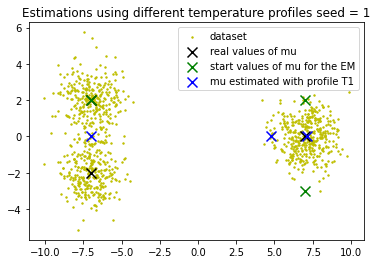

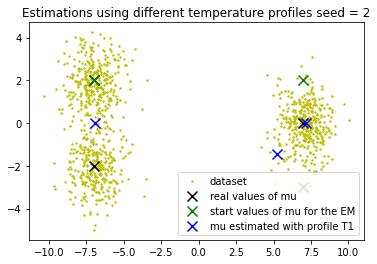

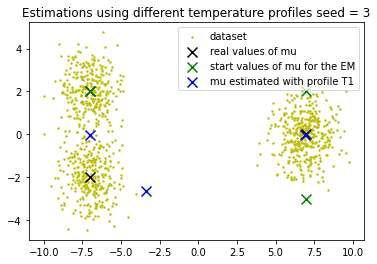

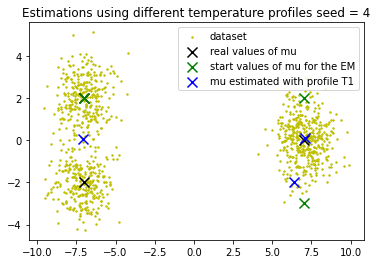

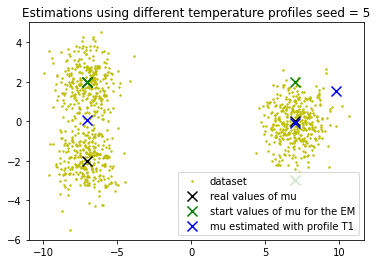

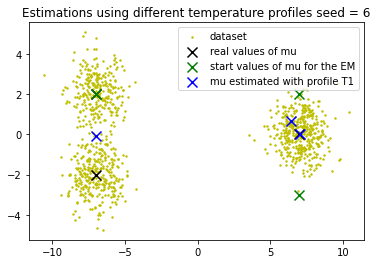

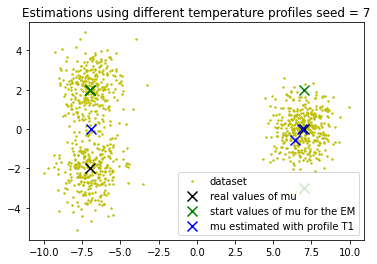

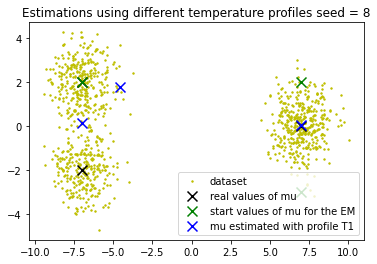

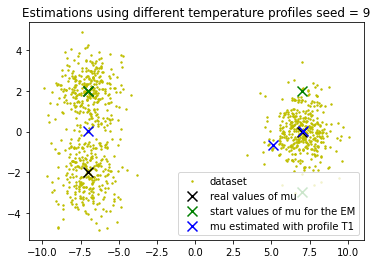

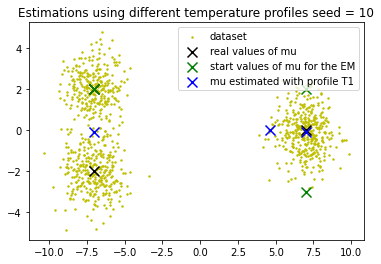

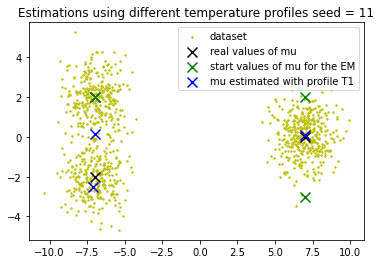

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


ValueError: ignored

In [ ]:
#this cell is to find a seed which actually works
m = 3
alpha = np.array([0.3, 0.3, 0.4])
mu = np.array([np.array([-7., -2.]), np.array([-7.,  2.]), np.array([7., 0.])])
sigma = np.array([np.eye(2) for _ in range(m)])
mu_start = np.array([np.array([7., -3.]), np.array([-7.,  2.]), np.array([7., 2.])])

# Generate hard observations 
N_obs = 1000

for seed in range(1,100):
    # Set model parameters
    np.random.seed(seed)
    # Generate hidden variables
    Z = generate(np.arange(0, 3), alpha, N_obs)
    Z = np.intc(Z)
    # Generate observations
    X = np.array([np.random.multivariate_normal(mean=mu[Z[i]], cov=sigma[Z[i]]) for i in range(N_obs)])
    # Estimate parameters
    #alpha_hard, mu_hard, sigma_hard = EM(X, m=3, d=2, mu_start=mu_start, T=T_const)
    alpha_temp_hard, mu_temp_hard, sigma_temp_hard = EM(X, m=3, d=2, mu_start=mu_start, T=T1)


    # Display
    plt.scatter(X[:,0], X[:,1], s=2, color='y', label="dataset")
    plt.scatter(mu[:,0], mu[:,1], marker='x', s = 100, c='k', label='real values of mu')
    plt.scatter(mu_start[:,0], mu_start[:,1], marker='x', s=100, c='g', label='start values of mu for the EM')
    plt.scatter(mu_temp_hard[:,0], mu_temp_hard[:,1], marker='x', s = 100, c='b', label='mu estimated with profile T1')

    plt.legend(loc="best")
    plt.title("Estimations using different temperature profiles seed = "+str(seed))
    plt.show()